<a href="https://colab.research.google.com/github/sp-au-mu-nl/SpeechComm/blob/main/notebook/chap10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://ss-takashi.sakura.ne.jp/corpus/jvnv/jvnv_ver1.zip

--2025-04-23 06:35:55--  https://ss-takashi.sakura.ne.jp/corpus/jvnv/jvnv_ver1.zip
Resolving ss-takashi.sakura.ne.jp (ss-takashi.sakura.ne.jp)... 219.94.162.51
Connecting to ss-takashi.sakura.ne.jp (ss-takashi.sakura.ne.jp)|219.94.162.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1778635432 (1.7G) [application/zip]
Saving to: ‘jvnv_ver1.zip’

jvnv_ver1.zip       100%[===================>]   1.66G  13.3MB/s    in 2m 57s  

2025-04-23 06:38:53 (9.56 MB/s) - ‘jvnv_ver1.zip’ saved [1778635432/1778635432]



In [ ]:
!unzip jvnv_ver1.zip

Archive:  jvnv_ver1.zip
   creating: jvnv_v1/
  inflating: jvnv_v1/transcription.pdf  
   creating: jvnv_v1/F1/
   creating: jvnv_v1/F1/surprise/
   creating: jvnv_v1/F1/surprise/free/
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_08.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_10.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_06.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_04.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_02.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_05.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_09.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_03.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_01.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_07.wav  
   creating: jvnv_v1/F1/surprise/regular/
  inflating: jvnv_v1/F1/surprise/regular/F1_surprise_regular_51.wav  
  inflating: jvnv_v1/F1/surprise/regular/F1_surprise_regular_50

プログラム 10.1

In [ ]:
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from pickle import FRAME

プログラム 10.2

In [ ]:
yA, sr = librosa.load('jvnv_v1/M2/sad/regular/M2_sad_regular_43.wav', sr=None)

VAD_THRESHOLD_RMS = 0.01
#VAD_THRESHOLD_NORM_RMS = 0.05
FRAME_LENGTH = int(0.1 * sr)
FRAME_SHIFT = 256
FRAME_SHIFT_SEC = FRAME_SHIFT / sr
SILENCE_THRESHOLD_FRAMES = 10

def calculate_vad(y, threshold, frame_length, frame_shift):
  frame_count = int(len(y) / frame_shift)
  vad = []

  for f in range(frame_count):
    frame = y[f*frame_shift:(f*frame_shift+frame_length)]
    rms = np.sqrt(np.mean(frame**2))
    vad.append(True if rms > threshold else False)

  return vad

vad = calculate_vad(yA, VAD_THRESHOLD_RMS, FRAME_LENGTH, FRAME_SHIFT)

プログラム 10.3

In [ ]:
def identify_silence(vad, silence_threshold_frames):
  silence_beg = []; silence_end = []; sil_counter = 0

  for i, v in enumerate(vad):
    if v:
      if sil_counter > 0:
        silence_end.append(i)
        sil_counter = 0
    else:
      if sil_counter == 0:
        silence_beg.append(i)
        sil_counter += 1

  if sil_counter > 0:
    silence_end.append(i+1)

  return silence_beg, silence_end

def compute_speech_intervals(silence_beg, silence_end,
                             silence_threshold_frames,
                             FRAME_SHIFT_SEC):
  ipu_beg_ms = []; ipu_end_ms = []; sil_counter = 0

  for beg, end in zip(silence_beg, silence_end):
    if end - beg > silence_threshold_frames:
      ipu_beg_ms.append(beg * FRAME_SHIFT_SEC)
      ipu_end_ms.append(end * FRAME_SHIFT_SEC)
      sil_counter += 1
      continue
    elif beg == 0:
      ipu_beg_ms.append(0)
      ipu_end_ms.append(0)
    sil_counter += 1

  if sil_counter == 0:
    ipu_beg_ms.append(end * FRAME_SHIFT_SEC)
    ipu_end_ms.append(end * FRAME_SHIFT_SEC)

  return ipu_beg_ms, ipu_end_ms

silence_beg, silent_end = identify_silence(vad, SILENCE_THRESHOLD_FRAMES)
ipu_beg_sec, ipu_end_sec = compute_speech_intervals(silence_beg, silent_end,
                                                  SILENCE_THRESHOLD_FRAMES,
                                                  FRAME_SHIFT_SEC)

print(ipu_beg_sec)
print(ipu_end_sec)

[0.0, 0.8906666666666666, 3.1466666666666665, 5.061333333333333, 5.386666666666667]
[0.5973333333333333, 1.888, 3.957333333333333, 5.1306666666666665, 6.256]


In [ ]:
def identify_silence(vad, silence_threshold_frames):
  silence_beg = []; silence_end = []; sil_counter = 0

  for i, v in enumerate(vad):
    if v:
      if sil_counter > 0:
        silence_end.append(i)
        sil_counter = 0
    else:
      if sil_counter == 0:
        silence_beg.append(i)
        sil_counter += 1

  if sil_counter > 0:
    silence_end.append(i+1)

  return silence_beg, silence_end

def compute_speech_intervals(silence_beg, silence_end,
                             silence_threshold_frames,
                             FRAME_SHIFT):
  ipu_beg_ms = []; ipu_end_ms = []

  for beg, end in zip(silence_beg, silence_end):
    if end - beg > silence_threshold_frames:
      ipu_beg_ms.append(beg * FRAME_SHIFT)
      ipu_end_ms.append(end * FRAME_SHIFT)

  return ipu_beg_ms, ipu_end_ms

silence_beg, silent_end = identify_silence(vad, SILENCE_THRESHOLD_FRAMES)
ipu_beg_ms, ipu_end_ms = compute_speech_intervals(silence_beg, silent_end,
                                                  SILENCE_THRESHOLD_FRAMES,
                                                  FRAME_SHIFT)

print(ipu_beg_ms)
print(ipu_end_ms)

[0, 42752, 151040, 242944, 258560]
[28672, 90624, 189952, 246272, 300288]


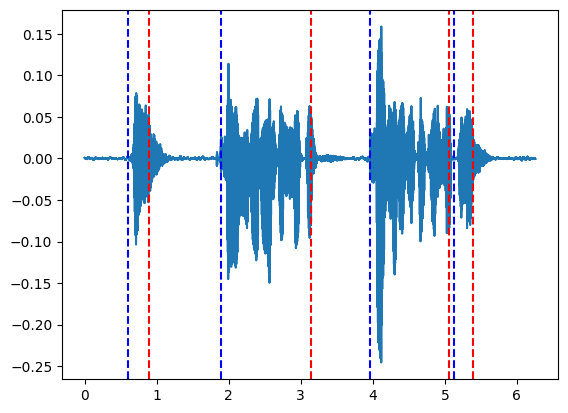

In [ ]:
t=np.arange(len(yA))/sr
fig, ax = plt.subplots()
plt.plot(t,yA)
for i in range(len(ipu_beg_sec)):
  if i > 0:
    ax.axvline(ipu_beg_sec[i],color='r',linestyle='--')
  if i < len(ipu_end_ms)-1:
    ax.axvline(ipu_end_sec[i],color='b',linestyle='--')

プログラム 10.4

Text(0, 0.5, 'log Fo_Range')

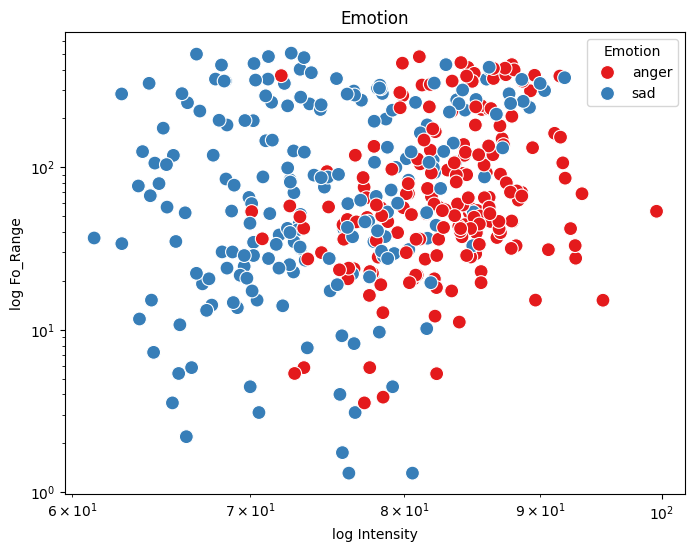

In [ ]:
def getNvTime(nv_label_file):
  f = open(nv_label_file, 'r', encoding='UTF-8')
  nv_beg, nv_end, nv = f.read().strip('\n').split('\t')
  f.close()
  return float(nv_beg), float(nv_end)

def getAcousticFeature(wav_data_nv):
  squared_wav_data_nv = np.square(wav_data_nv)
  rms = np.sqrt(np.mean(squared_wav_data_nv))
#  print(f'RMS: {rms}')
  pitch_floor = 75
  effective_window_length = int(3.2 / pitch_floor * sr)
  kaiser_window = signal.windows.kaiser(effective_window_length,
                                        beta = 20)
  intensity_wave = np.convolve(squared_wav_data_nv, kaiser_window,
                               mode='same')
  reference_pressure = 20e-6
  intensity_dB = 10 * np.log10(intensity_wave /
   (reference_pressure ** 2) + 1e-10)
  intensity = np.mean(intensity_dB)
#  print(f'Intensity: {intensity} dB')
  fo, _, _ = librosa.pyin(wav_data_nv, fmin=75, fmax=600)
  fo = fo[~np.isnan(fo)]
  if len(fo) != 0:
    fo_range = np.max(fo) - np.min(fo)
  else:
    fo_range = 0

  return intensity, fo_range

jvnv_path = './jvnv_v1/'
speaker_list = ['F1', 'F2', 'M1', 'M2']
emotion_list = ['anger', 'sad']
speaker = []; emotion = []; feat1 = []; feat2 = []
for s in speaker_list:
  for e in emotion_list:
    wav_dir = jvnv_path + s + '/' + e + '/regular/'
    nv_label_dir = jvnv_path + 'nv_label/' + s + '/'
    files = glob.glob(wav_dir + "*.wav")
    for f in files:
      nv_label_file = f.replace(wav_dir, nv_label_dir).replace('.wav','.txt')
      nv_beg, nv_end = getNvTime(nv_label_file)
      wav_data, sr = librosa.load(f, sr=None)
      wav_data_nv = wav_data[round(nv_beg * sr):round(nv_end * sr)]
      intensity, fo_range = getAcousticFeature(wav_data_nv)

      speaker.append(s)
      emotion.append(e)
      feat1.append(intensity)
      feat2.append(fo_range)

df = pd.DataFrame({'Emotion': emotion,
                   'Intensity': feat1,
                   'Fo_Range': feat2})

fig, ax = plt.subplots(figsize=(8,6))
ax.set(xscale='log',yscale='log')
sns.scatterplot(x='Intensity', y='Fo_Range', hue='Emotion',
                ax=ax, data=df, palette='Set1', s=100)
plt.title('Emotion')
plt.xlabel('log Intensity')
plt.ylabel('log Fo_Range')